In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

import folium
from folium import Map
import branca

%matplotlib inline

In [2]:
conn = sqlite3.connect('./Data/ChildAbuse.db')
curs = conn.cursor()

In [3]:
fatal = pd.read_sql("""SELECT *
                FROM data1
                WHERE NOT State like 'Puerto Rico' AND NOT state like 'National'

;""", conn)
fatal.columns = ['State', 'Report_Child_File', 'Report_Agency_File', 'Total_Fatalities', 'Rate']


In [4]:
fatal['Rate'] = pd.to_numeric(fatal['Rate'].replace('-','0'))

In [5]:
victims_per_state = pd.read_sql("""SELECT State, Victims
                                    FROM data5;""", conn)
victims_per_state

,State,Victims
0,Alabama,"12,158"
1,Alaska,"2,615"
2,Arizona,"15,504"
3,Arkansas,"8,538"
4,California,"63,795"
5,Colorado,"11,879"
6,Connecticut,"7,652"
7,Delaware,"1,251"
8,District of Columbia,"1,699"
9,Florida,"36,795"


In [6]:
for i in range(53):
    victims_per_state['Victims'][i] = victims_per_state['Victims'][i].replace(',','')
victims_per_state['Victims'] = pd.to_numeric(victims_per_state['Victims'])

In [7]:
victims_per_state.drop(39, inplace = True)
victims_per_state.drop(52, inplace = True)
victims_per_state.reset_index(drop = True, inplace = True)
victims_per_state

,State,Victims
0,Alabama,12158
1,Alaska,2615
2,Arizona,15504
3,Arkansas,8538
4,California,63795
5,Colorado,11879
6,Connecticut,7652
7,Delaware,1251
8,District of Columbia,1699
9,Florida,36795


In [8]:
victims_per_state['fatality_rate_per_100k'] = fatal['Rate']

In [9]:
states_json = './Data/gz_2010_us_040_00_500k.json'
census = pd.read_csv('./Data/census.csv')
under18 = pd.read_csv('./Data/popbystate.csv')


In [13]:
def MakeChoropleth(data, column, legend_name, bins, colormap='YlGn', layer_name=None):
    
    if type(bins) == int:
        min_column = np.floor(min(data[column]))
        max_column = np.ceil(max(data[column]))
        bins = np.linspace(min_column, max_column, bins+1)
    else:
        min_column = min(bins)
        max_column = max(bins)
    
    if layer_name == None:
        layer_name = column
    
    c = folium.Choropleth(
            geo_data = states_json,
            data = data,
            columns = ['State', column],
            key_on = 'feature.properties.NAME',
            fill_color=colormap,
            fill_opacity=1,
            legend_name = legend_name,
            bins = bins,
            line_color='grey',
            line_opacity=0.8,
            line_weight=0.5,
            overlay=True,
            name = layer_name
            )
    return c, min_column, max_column

In [14]:
cens = sqlite3.connect('Census.db')
curs = cens.cursor()

In [15]:
x = pd.read_sql("""SELECT name
                FROM sqlite_master
                WHERE type = 'table'
                AND name LIKE 't%';""",cens)
for table in x.values:
    sql = "PRAGMA table_info(" + table[0] + ");"
    print(table)
    print(pd.read_sql(sql,cens))
    print('\n')

['tCounty']
   cid       name     type  notnull dflt_value  pk
0    0  county_id  INTEGER        1       None   1
1    1     county     TEXT        1       None   0
2    2      state     TEXT        1       None   0


['tHousing']
   cid       name     type  notnull dflt_value  pk
0    0  county_id  INTEGER        1       None   1
1    1       year  INTEGER        1       None   2
2    2      units  INTEGER        1       None   0


['tEmployment']
   cid            name     type  notnull dflt_value  pk
0    0       county_id  INTEGER        1       None   1
1    1            year  INTEGER        1       None   2
2    2             pop  INTEGER        1       None   0
3    3         pop_err  INTEGER        1       None   0
4    4        lab_part  NUMERIC        1       None   0
5    5    lab_part_err  NUMERIC        1       None   0
6    6       emp_ratio  NUMERIC        1       None   0
7    7   emp_ratio_err  NUMERIC        1       None   0
8    8      unemp_rate  NUMERIC        1   

In [16]:
conn = sqlite3.connect('Final.db')
curs = conn.cursor()

In [17]:
st_chi_pop = pd.read_sql("""SELECT name, age, POPEST2018_CIV as ChildPop
                FROM Field
                WHERE AGE < 18 AND NOT NAME like 'United States' 
                GROUP BY state, age;""", conn)

In [18]:
curs.execute("""DROP TABLE IF EXISTS ChildState""")
st_chi_pop.to_sql('ChildState', conn, index = False)

In [19]:
st_chi_pop = pd.read_sql("""SELECT NAME, sum(ChildPop) as ChildPop
                FROM ChildState
                GROUP BY NAME;""", conn)


In [22]:
victims_per_state['PopUnder18'] = st_chi_pop['ChildPop']

In [23]:
victims_per_state['Percent_Victims'] = (victims_per_state['Victims']/st_chi_pop['ChildPop'])*100

In [24]:
victims_per_state.reset_index(drop = True, inplace = True)

In [25]:
victims_per_state['Percent_Victims'].nlargest()

17    2.358214
48    1.905959
21    1.891288
39    1.769181
22    1.743748
Name: Percent_Victims, dtype: float64

In [26]:
cens = sqlite3.connect('Census.db')
curs = cens.cursor()

In [27]:
median_inc = pd.read_sql("""SELECT state, sum(median_inc)/count(median_inc) as median_inc
            FROM tIncome
            JOIN tCounty 
            USING(county_id)
            WHERE year like 2017
            GROUP BY state;""", cens)

In [28]:
median_inc

,state,median_inc
0,Alabama,40271
1,Alaska,66425
2,Arizona,45816
3,Arkansas,39025
4,California,61046
5,Colorado,54353
6,Connecticut,74496
7,Delaware,61294
8,District of Columbia,77649
9,Florida,47144


In [29]:
pd.read_sql(""" SELECT *
                FROM tEmployment
                WHERE year like '2017'
;""", cens)

,county_id,year,pop,pop_err,lab_part,lab_part_err,emp_ratio,emp_ratio_err,unemp_rate,unemp_rate_err
0,1003,2017,172791,737,57.6,2.3,54.5,2.3,5.2,1.5
1,1015,2017,92869,428,56.5,2.8,52.6,2.7,6.5,2
2,1043,2017,66972,588,56,2.5,52,2.7,7.2,2.8
3,1049,2017,55888,591,53.7,2.9,51.5,3.2,4.1,2.5
4,1051,2017,65901,579,58,2.9,53.6,3.2,6.3,2.3
...,...,...,...,...,...,...,...,...,...,...
821,55133,2017,324687,818,67.7,0.9,65.7,1,2.8,0.4
822,55139,2017,139077,720,65.5,1.5,63.7,1.5,2.6,0.8
823,55141,2017,58995,472,63.3,2.6,61.6,2.7,2.7,1.1
824,56021,2017,78308,622,67.2,2.9,59.4,3.6,5.8,2.3


In [30]:
unemp = pd.read_sql("""SELECT state, county, pop, year, IFNULL(unemp_rate, 0) as unemp_rate
                FROM tEmployment
                JOIN tCounty USING (county_id)
                WHERE year like '2017'
                GROUP BY state, county;""", cens)
#unemp.to_csv('./Data/unemp_rate_county.csv')
unemp

,state,county,pop,year,unemp_rate
0,Alabama,Baldwin County,172791,2017,5.2
1,Alabama,Calhoun County,92869,2017,6.5
2,Alabama,Cullman County,66972,2017,7.2
3,Alabama,DeKalb County,55888,2017,4.1
4,Alabama,Elmore County,65901,2017,6.3
...,...,...,...,...,...
821,Wisconsin,Waukesha County,324687,2017,2.8
822,Wisconsin,Winnebago County,139077,2017,2.6
823,Wisconsin,Wood County,58995,2017,2.7
824,Wyoming,Laramie County,78308,2017,5.8


In [31]:
curs.execute("""DROP TABLE IF EXISTS Unemp""")
unemp.to_sql('Unemp', cens, index=False)

In [32]:
unemp = pd.read_sql("""SELECT state, count(county), sum(pop) as Pop, sum(unemp_rate)/count(county) as Unemp_Ratio
                FROM unemp
                GROUP BY state;""", cens)

In [42]:
victims_per_state['Unemp_Ratio'] = unemp['Unemp_Ratio']

In [43]:
victims_per_state['median_inc'] = median_inc['median_inc']


In [35]:
victims_per_state.to_csv('./Data/victims_per_state.csv')

In [36]:
victims_per_state['Unemp_Ratio'].nsmallest(10)

26    2.933333
49    3.378261
23    3.428571
44    3.442857
34    3.475000
27    3.533333
41    3.600000
15    3.730000
29    3.800000
12    4.100000
Name: Unemp_Ratio, dtype: float64

In [37]:
victims_per_state['Percent_Victims'].nsmallest(10)

38    0.177128
47    0.271271
33    0.282476
30    0.307916
46    0.328625
49    0.393478
25    0.411302
11    0.417849
12    0.431392
10    0.442421
Name: Percent_Victims, dtype: float64

In [38]:
victims_per_state['fatality_rate_per_100k'].nsmallest(11)

21    0.00
27    0.00
29    0.00
11    0.33
39    0.49
17    0.59
33    0.61
12    0.67
50    0.74
45    0.86
26    0.87
Name: fatality_rate_per_100k, dtype: float64

In [39]:
victims_per_state['median_inc'].nlargest(10)

8     77649
30    77047
6     74496
20    72541
21    71030
39    69906
11    68663
1     66425
29    64901
7     61294
Name: median_inc, dtype: int64

In [40]:
corr = victims_per_state[['fatality_rate_per_100k', 'Percent_Victims', 'Unemp_Ratio', 'median_inc']]
corr = corr.corr()

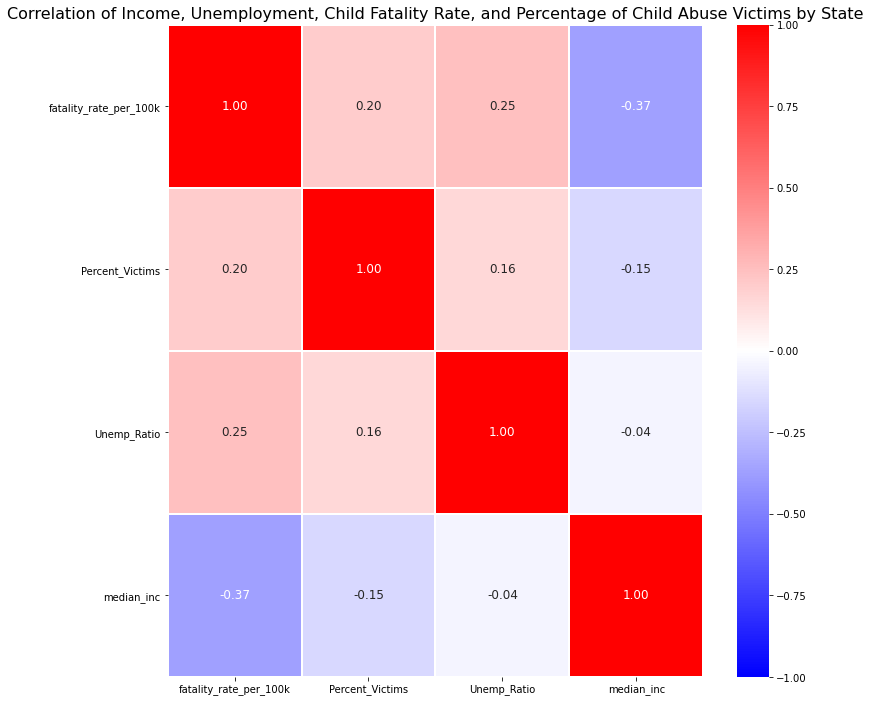

In [41]:
import seaborn as sns
plt.figure(figsize = (12,12))
sns.heatmap(corr, cmap='bwr', 
            vmin=-1,vmax=1,annot=True, 
            fmt='.2f',annot_kws={'size':12}, linewidths=.05)
plt.yticks(rotation=0)
plt.title('Correlation of Income, Unemployment, Child Fatality Rate, and Percentage of Child Abuse Victims by State', fontsize = 16)
plt.savefig('Correlation_Final.png', bbox_inches = 'tight')
plt.show()
